# Loading Packages

In [1]:
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
import random 
import math
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as torch_utils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn.functional as F
import d2l
import time
import traceback
import fastprogress
from torchmetrics.classification import BinaryAccuracy, Accuracy 
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from itertools import repeat

In [2]:
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Set the device to the first available GPU
    device = torch.device("cuda:0")
else:
    # If GPU is not available, use the CPU
    device = torch.device("cpu")

# Loading Data (with scaling)

In [4]:
# Custom Dataset class for loading data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Implement data retrieval for each index
        input_data = self.X[idx]
        target_data = self.y[idx]
        input_data = input_data.unsqueeze(0)
        
        # Convert data to torch tensors if required
        input_tensor = torch.Tensor(input_data)
        target_tensor = torch.Tensor(target_data)
        
        return input_tensor, target_tensor

In [5]:
shift = 13
set_values = [4,5]
model_name = 's_'+str(shift)+'_'+str(set_values)
labels = ['s_1','s_2','s_3','s_4']
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']

In [6]:
#with scaling
df_human = pd.read_csv("data_human_filtered.csv")
df_human = df_human.drop(columns='id')
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)
#df = df[columns_to_keep]
# Step 1: Separate 'id' and 'trial' columns from the rest of the data
data_to_scale = df.drop(columns=['id', 'trial'])

# Step 2: Apply MinMaxScaler to the remaining columns
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)

# Step 3: Merge 'id' and 'trial' columns with the scaled data
scaled_df[['id', 'trial']] = df[['id', 'trial']]

# Step 4: create variable t-1
# List of columns to shift
columns_to_shift = ['s_1', 's_2', 's_3','s_4']  # List all column names here

# Create shifted columns for each column in the list
for col in columns_to_shift:
    new_col_name = col + '_minus_' + str(shift)
    scaled_df[new_col_name] = scaled_df[col].shift(shift)
    scaled_df[new_col_name] = scaled_df[new_col_name].fillna(1)  # Fill NaN in the first row with 1
    scaled_df[new_col_name] = scaled_df[new_col_name].astype(int)

#desired_column_order = [col for col in scaled_df.columns if col not in columns_to_shift] + columns_to_shift
#scaled_df = scaled_df[desired_column_order]
selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
scaled_df = scaled_df[selected_columns]
# Step 5: Split the data into training and test sets based on the 'trial' column
train_set = scaled_df[-scaled_df['trial'].isin(set_values)].drop(columns=['id', 'trial'])
test_set = scaled_df[scaled_df['trial']==set_values[0]].drop(columns=['id', 'trial'])
val_set = scaled_df[scaled_df['trial']==set_values[1]].drop(columns=['id', 'trial'])
full_set = scaled_df.drop(columns=['id','trial'])

# split data into x and y 
X_train, y_train = train_set.drop(columns=labels), train_set[labels]
X_test, y_test = test_set.drop(columns=labels), test_set[labels]
X_val, y_val = val_set.drop(columns=labels), val_set[labels]
X, y = full_set.drop(columns=labels), full_set[labels]


# reset index 
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
X, y = X.reset_index(drop=True), y.reset_index(drop=True) 



# Create custom datasets for training, validation, and testing
full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
val_dataset = MyDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))
test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

# Create a DataLoader
#batch_size = 5561#67  # Set your desired batch size
#shuffle = False  # Set to False to preserve the order of your data
fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)

# Model Architecture

In [7]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2, bidirectional=False):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)
        #Xavier initialization for GRU weights
        #for name, param in self.gru.named_parameters():
        #    if 'weight' in name:
        #        init.xavier_uniform_(param.data)
        #    elif 'bias' in name:
        #        init.constant_(param.data, 0.0)
                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sotfplus = nn.Softplus()
        self.relu = nn.ReLU()

        
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.sotfplus(out[:,-1]))
        #out = self.fc(self.relu(out[:,-1]))
        out = F.softmax(out, dim=1)
        return out, h
    
    #def init_hidden(self, batch_size):
        #weight = next(self.parameters()).data
        #hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        #return hidden
    def init_hidden(self, batch_size):
        if batch_size > 1:
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        else:
            weight = next(self.parameters()).data
            hidden = weight.new(self.n_layers, self.hidden_dim).zero_().to(device)
        return hidden

In [8]:
class GRUCellNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRUCell(input_dim, hidden_dim, bias=True)                
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

        self.gru_cells = nn.ModuleList([
            nn.GRUCell(input_dim, hidden_dim) if i == 0 else nn.GRUCell(hidden_dim, hidden_dim)
            for i in range(num_layers)
        ])
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # Add BatchNorm outside GRU cells

        
        
    def forward(self, x, h=None):
        if h is None:
            h = [torch.zeros(x.size(0), self.hidden_dim) for _ in range(self.num_layers)]
        
        hidden_states = []
        
        for t in range(x.size(1)):
            input_t = x[:, t, :]
            new_hidden_states = []
            for layer_idx, gru_cell in enumerate(self.gru_cells):
                h[layer_idx] = gru_cell(input_t, h[layer_idx])
                new_hidden_states.append(h[layer_idx])
                input_t = h[layer_idx]  # Update input_t with the new hidden state for the next layer
            hidden_states.append(new_hidden_states)
        
        last_hidden_states = [layer_states[-1] for layer_states in hidden_states]
        # Apply BatchNorm to the last hidden state
        last_hidden_states[-1] = self.batch_norm(last_hidden_states[-1])
        out = self.fc(self.softplus(last_hidden_states[-1]))
        
        return out, last_hidden_states 

# Training functions

In [9]:
def accuracy(correct, total):
    return float(correct)/total

In [10]:
def train(dataloader, model, optimizer, loss_fn, scheduler=None, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device)
    model.train()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    for x, y in dataloader:
        x = x.to(device).float()
        y = y.to(device).float()
        
        optimizer.zero_grad()
        
        out, last_hidden_states = model(x)
        y_prob = torch.sigmoid(out)
        # Append the predicted probabilities to the list
        predicted_probs.append(y_prob.cpu().detach().numpy())
        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())

        #hidden_states.append(hidden)
        
        y_pred = torch.round(y_prob)
        epoch_correct += sum((y == y_pred).flatten()).item()
        epoch_total += y.numel()
        
        loss.backward()
        torch_utils.clip_grad_norm_(model.parameters(), max_norm=10)
        optimizer.step()

        predicted_labels.extend(zip(y_pred.cpu().detach().cpu().numpy(), y.cpu().numpy()))
        if scheduler:
            scheduler.step()
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs 

In [11]:
def validate(dataloader, model, loss_fn, device=None):
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    model = model.to(device).float()
    model.eval()
    predicted_probs = []
    predicted_labels = []
    #hidden_states = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device).float()
            y = y.to(device).float()
            
            out, last_hidden_states = model(x)
            
            loss = loss_fn(out, y)
            epoch_loss.append(loss.item())

            #hidden_states.append(hidden)
            y_pred = torch.sigmoid(out)
            predicted_probs.append(y_pred.cpu().detach().numpy())
            y_pred = torch.round(y_pred)
            epoch_correct += sum((y == y_pred).flatten())
            epoch_total += y.numel()
            predicted_labels.extend(zip(y_pred.cpu().numpy(), y.cpu().numpy()))
    
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), predicted_labels, predicted_probs

In [12]:
def run_training(train_dataloader, val_dataloader, model, optimizer, loss_fn, num_epochs, scheduler=None, device=None, schedule_on_train=True, verbose=True):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    #train_hidden_states, val_hidden_states = [], []
    
    for epoch in range(num_epochs):
        epoch_train_loss, epoch_train_acc, train_preds, train_probs = train(train_dataloader, model, optimizer, loss_fn, scheduler, device)
        
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        #train_hidden_states.extend(train_hidden)
        
        if val_dataloader is not None:
            epoch_val_loss, epoch_val_acc, val_preds, val_probs = validate(val_dataloader, model, loss_fn, device)
        
            val_losses.append(epoch_val_loss)
            val_accs.append(epoch_val_acc)

            #val_hidden_states.extend(val_hidden)
        
        #if isinstance(scheduler, ReduceLROnPlateau):
        #    scheduler.step(epoch_train_acc if schedule_on_train or val_dataloader is None else epoch_val_acc)
            
        if epoch % 50 == 0:
            val_str = f", val loss: {epoch_val_loss}, val acc: {epoch_val_acc}" if val_dataloader is not None else ""
            print(f"Epoch {epoch}, train loss: {epoch_train_loss}, train acc: {epoch_train_acc}{val_str}")
        if epoch == num_epochs - 1:  # Store values only for the final epoch
            train_predicted_labels = train_preds
            #val_predicted_labels = val_preds
            train_probs_final = train_probs
            #val_probs_final = val_probs
            if val_dataloader is not None:
                val_predicted_labels = val_preds
                val_probs_final = val_probs

    if val_dataloader is not None:        
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, val_predicted_labels, train_probs_final, val_probs_final
    else: 
        return train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final

# Testing

In [13]:

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =251
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

In [14]:
train_losses, train_accs, val_losses, val_accs, train_predicted, val_predicted, train_probs, val_probs= run_training(
    train_dataloader, val_dataloader=val_dataloader, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)

Epoch 0, train loss: 0.973007082939148, train acc: 0.5710994075049375, val loss: 0.9252921342849731, val acc: 0.6156462585034014
Epoch 50, train loss: 0.1900331974029541, train acc: 0.9609529295589203, val loss: 0.2454943209886551, val acc: 0.95578231292517
Epoch 100, train loss: 0.1826012283563614, train acc: 0.9609529295589203, val loss: 0.21370013058185577, val acc: 0.95578231292517
Epoch 150, train loss: 0.18041697144508362, train acc: 0.9609529295589203, val loss: 0.20905563235282898, val acc: 0.95578231292517
Epoch 200, train loss: 0.1794201135635376, train acc: 0.9609529295589203, val loss: 0.21031486988067627, val acc: 0.95578231292517
Epoch 250, train loss: 0.17882075905799866, train acc: 0.9609529295589203, val loss: 0.21055826544761658, val acc: 0.95578231292517


In [29]:
max(val_accs)

0.95578231292517

In [15]:
X_train

,s_1_minus_13,s_2_minus_13,s_3_minus_13,s_4_minus_13
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
6071,1,1,0,0
6072,1,1,0,0
6073,1,1,0,0
6074,1,1,0,0


In [16]:

# Create the folder if it doesn't exist
#os.makedirs(save_folder, exist_ok=True)
#os.makedirs(folder_path, exist_ok=True)
# Assuming your model is named 'model'
state_dict = model.state_dict()

# Specify the folder path and the model filename
folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
model_filename = model_name + '.pth'  

# Combine the folder path and model filename
full_model = os.path.join(folder_path, model_filename)

# Save the model to the specified folder
torch.save(state_dict, full_model)

In [17]:
# Load the saved weights into the model
#torch.save(model.state_dict(), 'model_weights.pth')
#zmodel = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load(full_model))
model.eval()  # Set the model in evaluation mode


GRUCellNet(
  (gru): GRUCell(4, 34)
  (fc): Linear(in_features=34, out_features=4, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
  (relu): ReLU()
  (gru_cells): ModuleList(
    (0): GRUCell(4, 34)
  )
  (batch_norm): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# Predictions

In [18]:

model.load_state_dict(torch.load(full_model))
model.eval()  # Set the model to evaluation mode
# Initialize an empty list to store predictions
all_preds = []
all_probs = []

# Iterate through the test data batches
for inputs, _ in test_dataloader:
    inputs = inputs.float()
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, _ = model(inputs)
        probabilities = torch.sigmoid(predictions)
        preds = torch.round(probabilities)

    # Append predictions to the list
    all_preds.append(preds)
    all_probs.append(probabilities)

# Concatenate the predicted batches
all_preds = torch.cat(all_preds, dim=0)
all_probs = torch.cat(all_probs, dim=0)

all_preds_array = all_preds.numpy()
all_probs_array = all_probs.numpy()


columns = ['s_1','s_2','s_3','s_4']
all_probs_df = pd.DataFrame(all_probs_array)
all_probs_df.columns = columns
# Convert the tensor of predictions to a DataFrame
predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
# Calculate accuracy for each output state
accuracies = (predictions_df == y_test).mean()

print("Accuracy for each output state:")
print(np.mean(accuracies))

          s_1       s_2       s_3       s_4
0    0.984346  0.997641  0.981565  0.918865
1    0.984346  0.997641  0.981565  0.918865
2    0.984346  0.997641  0.981565  0.918865
3    0.984346  0.997641  0.981565  0.918865
4    0.984346  0.997641  0.981565  0.918865
..        ...       ...       ...       ...
430  0.160832  0.157984  0.155199  0.997321
431  0.160832  0.157984  0.155199  0.997321
432  0.160832  0.157984  0.155199  0.997321
433  0.160832  0.157984  0.155199  0.997321
434  0.160832  0.157984  0.155199  0.997321

[435 rows x 4 columns]


In [19]:
# Convert the tensor of predictions to a DataFrame
predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
# Calculate accuracy for each output state
accuracies = (predictions_df == y_test).mean()

print("Accuracy for each output state:")
print(np.mean(accuracies))

Accuracy for each output state:
0.9775862068965517


model_name

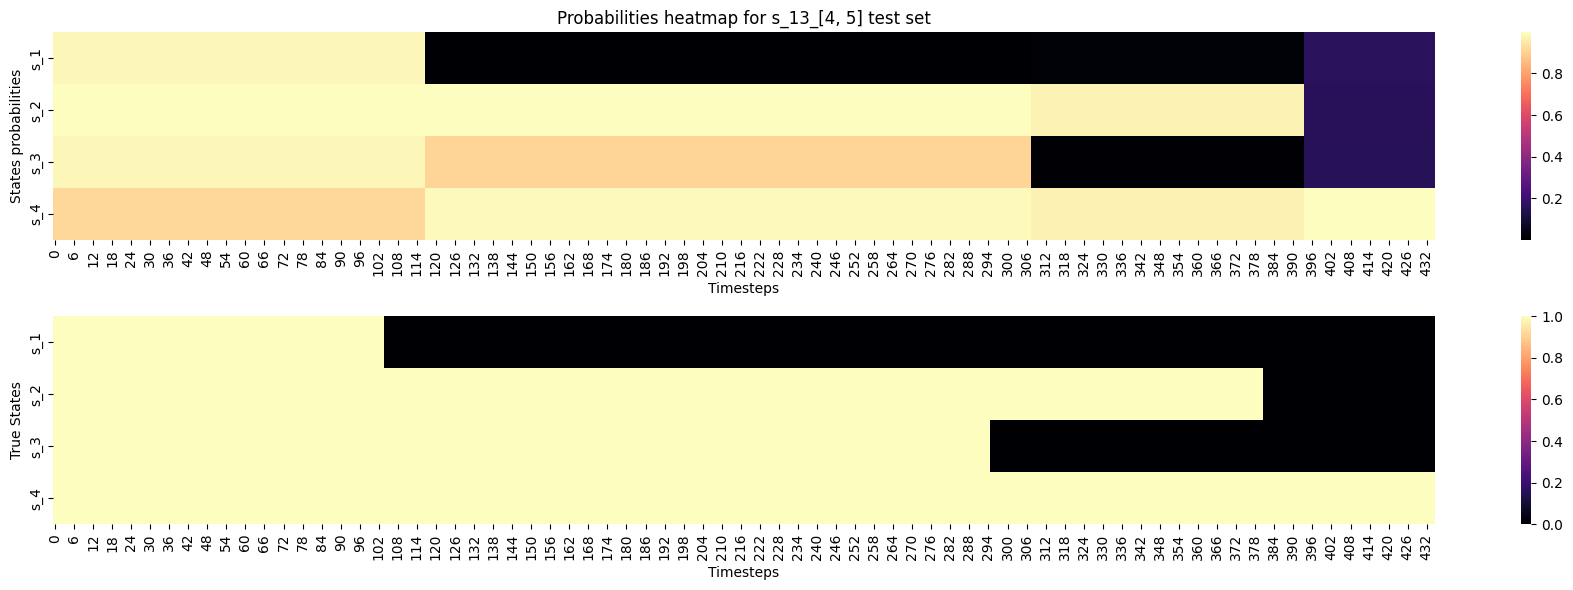

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(18, 6)) 
# Add labels and a title


# Show the plot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
plt.title("Probabilities heatmap for "+model_name+' test set')  # Replace with your title
sns.heatmap(all_probs_df.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("States probabilities")  # Replace with your y-axis label

plt.subplot(2, 1, 2)
sns.heatmap(y_test.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("True States")  # Replace with your y-axis label


# Define the folder where you want to save the plot
save_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots'

# Create the folder if it doesn't exist
#os.makedirs(save_folder, exist_ok=True)

# Specify the full file path including the folder to save the plot
save_path = os.path.join(save_folder,model_name+'_test.png')

# Save the plot to the specified folder and file
plt.savefig(save_path, dpi=100, bbox_inches='tight')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

plt.savefig(model_name+'_test.png')

# plot on val data

In [21]:
model.eval()  # Set the model to evaluation mode
# Initialize an empty list to store predictions
all_preds = []
all_probs = []

# Iterate through the test data batches
for inputs, _ in val_dataloader:
    inputs = inputs.float()
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, _ = model(inputs)
        probabilities = torch.sigmoid(predictions)
        preds = torch.round(probabilities)

    # Append predictions to the list
    all_preds.append(preds)
    all_probs.append(probabilities)

# Concatenate the predicted batches
all_preds = torch.cat(all_preds, dim=0)
all_probs = torch.cat(all_probs, dim=0)

all_preds_array = all_preds.numpy()
all_probs_array = all_probs.numpy()


columns = ['s_1','s_2','s_3','s_4']
all_probs_df = pd.DataFrame(all_probs_array)
all_probs_df.columns = columns
print(all_probs_df)

          s_1       s_2       s_3       s_4
0    0.160832  0.157984  0.155199  0.997321
1    0.160832  0.157984  0.155199  0.997321
2    0.160832  0.157984  0.155199  0.997321
3    0.160832  0.157984  0.155199  0.997321
4    0.160832  0.157984  0.155199  0.997321
..        ...       ...       ...       ...
436  0.312212  0.282847  0.990955  0.281307
437  0.312212  0.282847  0.990955  0.281307
438  0.312212  0.282847  0.990955  0.281307
439  0.312212  0.282847  0.990955  0.281307
440  0.312212  0.282847  0.990955  0.281307

[441 rows x 4 columns]


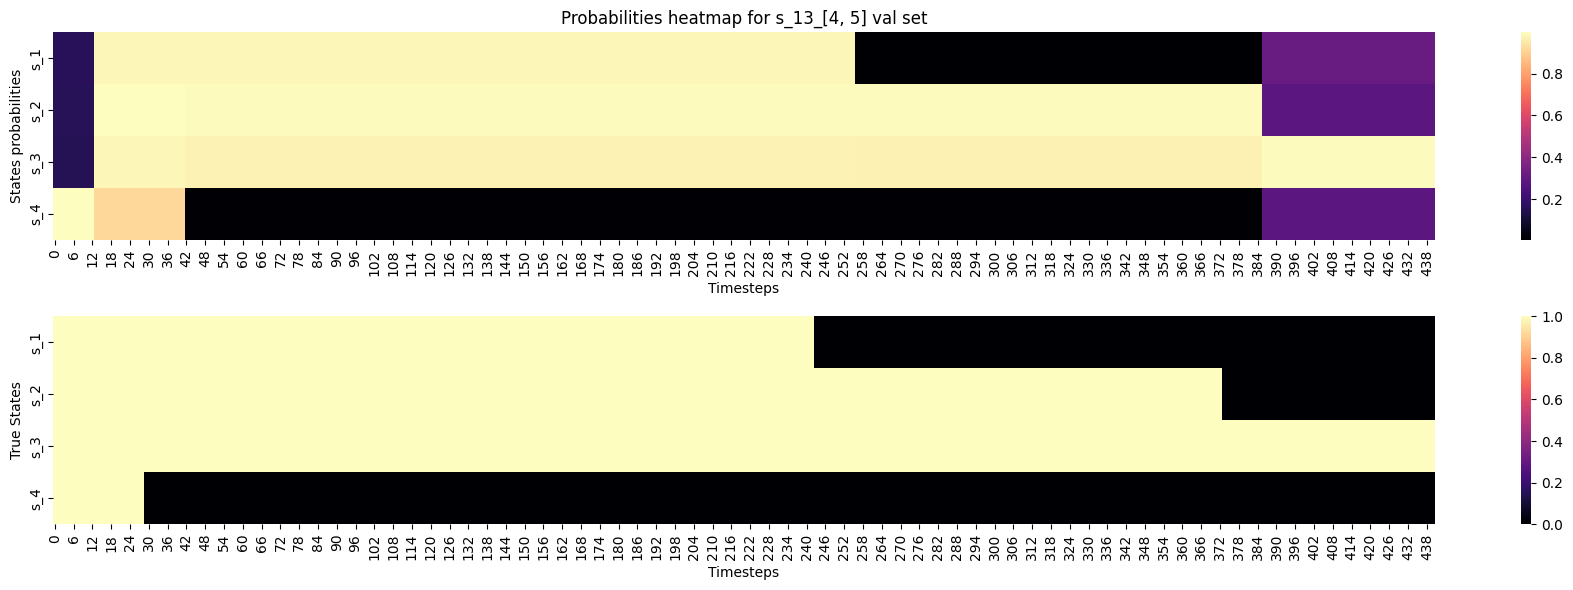

In [22]:
plt.figure(figsize=(18, 6)) 
# Add labels and a title


# Show the plot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
plt.title("Probabilities heatmap for "+model_name+' val set')  # Replace with your title
sns.heatmap(all_probs_df.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("States probabilities")  # Replace with your y-axis label

plt.subplot(2, 1, 2)
sns.heatmap(y_val.transpose(),linewidth=.001, cmap="magma")
plt.xlabel("Timesteps")  # Replace with your x-axis label
plt.ylabel("True States")  # Replace with your y-axis label


# Define the folder where you want to save the plot
save_folder = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/plots'

# Create the folder if it doesn't exist
#os.makedirs(save_folder, exist_ok=True)

# Specify the full file path including the folder to save the plot
save_path = os.path.join(save_folder,model_name+'_val.png')

# Save the plot to the specified folder and file
#plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

#plt.savefig(model_name+'_test.png')

In [23]:
X_val

,s_1_minus_13,s_2_minus_13,s_3_minus_13,s_4_minus_13
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
436,0,0,1,0
437,0,0,1,0
438,0,0,1,0
439,0,0,1,0


In [24]:
#shift = 10
#model_name = 's_minus_10'

# Specify the folder path and the model filename
folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
model_filename = model_name + '.pth'  

# Combine the folder path and model filename
full_model = os.path.join(folder_path, model_filename)

model.load_state_dict(torch.load(full_model))

model.eval()  # Set the model to evaluation mode
# Initialize an empty list to store predictions
all_preds = []
all_probs = []

# Iterate through the test data batches
for inputs, _ in test_dataloader:
    inputs = inputs.float()
    # Forward pass to get predictions
    with torch.no_grad():
        predictions, _ = model(inputs)
        probabilities = torch.sigmoid(predictions)
        preds = torch.round(probabilities)

    # Append predictions to the list
    all_preds.append(preds)
    all_probs.append(probabilities)

# Concatenate the predicted batches
all_preds = torch.cat(all_preds, dim=0)
all_probs = torch.cat(all_probs, dim=0)

all_preds_array = all_preds.numpy()
all_probs_array = all_probs.numpy()


columns = ['s_1','s_2','s_3','s_4']
all_probs_df = pd.DataFrame(all_probs_array)
all_probs_df.columns = columns



# Convert the tensor of predictions to a DataFrame
predictions_df = pd.DataFrame(all_preds.numpy(), columns=y_test.columns, index=y_test.index)
# Calculate accuracy for each output state
accuracies = (predictions_df == y_test).mean()

print("Accuracy for each output state:")
print(np.mean(accuracies))

Accuracy for each output state:
0.9775862068965517


In [25]:
print(all_preds)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]])


In [26]:
print(y_test)

     s_1  s_2  s_3  s_4
0    1.0  1.0  1.0  1.0
1    1.0  1.0  1.0  1.0
2    1.0  1.0  1.0  1.0
3    1.0  1.0  1.0  1.0
4    1.0  1.0  1.0  1.0
..   ...  ...  ...  ...
430  0.0  0.0  0.0  1.0
431  0.0  0.0  0.0  1.0
432  0.0  0.0  0.0  1.0
433  0.0  0.0  0.0  1.0
434  0.0  0.0  0.0  1.0

[435 rows x 4 columns]


# training loop 

In [159]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = ['s_1','s_2','s_3','s_4']
columns_to_shift

['s_1', 's_2', 's_3', 's_4']

In [160]:
# Hyperparameters
input_dim = 4
hidden_dim = 4
output_dim = 4
num_layers = 1
n_epochs =101
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [165]:
for j in np.arange(1,16):
    for i in np.arange(1,150,step=10):
        shift = i
        set_values = j
        model_name = 's_'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial', 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)



        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()

        print("Accuracy for each output state:")
        print(np.mean(accuracies))
        test_accs = np.mean(accuracies)
        
        
        file_name = 's_results.txt'
        file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/" + file_name  # Replace with your desired file path
        value_to_save = model_name+": "+str(test_accs)  # Replace with the value you want to save

        try:
            with open(file_path, "a") as file:
                # 2. Write the value to the file
                file.write(value_to_save)
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    








Epoch 0, train loss: 0.14204613864421844, train acc: 0.9749292206824617
Epoch 50, train loss: 0.12156768143177032, train acc: 0.9861794069438236
Epoch 100, train loss: 0.10827517509460449, train acc: 0.9861794069438236
Accuracy for each output state:
0.9984375
Value 's_1_val1: 0.9984375' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/s_results.txt' successfully.
Epoch 0, train loss: 0.1652335226535797, train acc: 0.97466139096028
Epoch 50, train loss: 0.1549750119447708, train acc: 0.97466139096028
Epoch 100, train loss: 0.14959540963172913, train acc: 0.97466139096028
Accuracy for each output state:
0.9816666666666667
Value 's_11_val1: 0.9816666666666667' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/s_results.txt' successfully.
Epoch 0, train loss: 0.20221301913261414, train acc: 0.9589488415487483
Epoch 50, train loss: 0.19554823637008667, train acc: 0.9589488415487483
Epoch 100, train loss: 0.19260020554065704, train acc: 0.958

In [166]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['nose_x', 'nose_y', 'nose_z', 'headTop_x', 'headTop_y', 'headTop_z',
       'neck_x', 'neck_y', 'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z',
       'lEar_x', 'lEar_y', 'lEar_z', 'lShoulder_x', 'lShoulder_y',
       'lShoulder_z', 'lElbow_x', 'lElbow_y', 'lElbow_z', 'lWrist_x',
       'lWrist_y', 'lWrist_z', 'lHip_x', 'lHip_y', 'lHip_z', 'rEar_x',
       'rEar_y', 'rEar_z', 'rShoulder_x', 'rShoulder_y', 'rShoulder_z',
       'rElbow_x', 'rElbow_y', 'rElbow_z', 'rWrist_x', 'rWrist_y', 'rWrist_z',
       'rHip_x', 'rHip_y', 'rHip_z', 's_1', 's_2', 's_3', 's_4'],
      dtype='object')

In [167]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =151
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [169]:
for j in np.arange(1,16):
    for i in np.arange(1,151,step=10):
        shift = i
        set_values = j
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)



        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()

        print("Accuracy for each output state:")
        print(np.mean(accuracies))
        test_accs = np.mean(accuracies)
        
        
        file_name = 'sm_results.txt'
        file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/" + file_name  # Replace with your desired file path
        value_to_save = model_name+": "+str(test_accs)  # Replace with the value you want to save

        try:
            with open(file_path, "a") as file:
                # 2. Write the value to the file
                file.write(value_to_save)
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    








Epoch 0, train loss: 0.026841944083571434, train acc: 0.9976903591119058
Epoch 50, train loss: 0.01070847176015377, train acc: 0.9984726568320668
Epoch 100, train loss: 0.009822231717407703, train acc: 0.9984726568320668
Epoch 150, train loss: 0.009426278062164783, train acc: 0.9984726568320668
Accuracy for each output state:
0.9984375
Value 's_m1_val1: 0.9984375' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/sm_results.txt' successfully.
Epoch 0, train loss: 0.07457495480775833, train acc: 0.9828412722568863
Epoch 50, train loss: 0.04239916056394577, train acc: 0.9872165576015827
Epoch 100, train loss: 0.03924467787146568, train acc: 0.9878633389134074
Epoch 150, train loss: 0.03724725544452667, train acc: 0.9884340283061939
Accuracy for each output state:
0.9783333333333333
Value 's_m11_val1: 0.9783333333333333' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/sm_results.txt' successfully.
Epoch 0, train loss: 0.07064522057771683, 

In [170]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns='H_id')
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['H_headFront_x', 'H_headFront_y', 'H_headFront_z', 'H_neck_x',
       'H_neck_y', 'H_neck_z', 'H_lowerBack_x', 'H_lowerBack_y',
       'H_lowerBack_z', 'H_leftWrist_x', 'H_leftWrist_y', 'H_leftWrist_z',
       'H_leftShoulder_x', 'H_leftShoulder_y', 'H_leftShoulder_z',
       'H_leftElbow_x', 'H_leftElbow_y', 'H_leftElbow_z', 'nose_x', 'nose_y',
       'nose_z', 'headTop_x', 'headTop_y', 'headTop_z', 'neck_x', 'neck_y',
       'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z', 'lEar_x', 'lEar_y',
       'lEar_z', 'lShoulder_x', 'lShoulder_y', 'lShoulder_z', 'lElbow_x',
       'lElbow_y', 'lElbow_z', 'lWrist_x', 'lWrist_y', 'lWrist_z', 'lHip_x',
       'lHip_y', 'lHip_z', 'rEar_x', 'rEar_y', 'rEar_z', 'rShoulder_x',
       'rShoulder_y', 'rShoulder_z', 'rElbow_x', 'rElbow_y', 'rElbow_z',
       'rWrist_x', 'rWrist_y', 'rWrist_z', 'rHip_x', 'rHip_y', 'rHip_z', 's_1',
       's_2', 's_3', 's_4'],
      dtype='object')

In [171]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 46
output_dim = 4
num_layers = 1
n_epochs =201
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [172]:
# finished smh, left set 14,15 to train 
for j in np.arange(1,16):
    for i in np.arange(0,152,step=10):
        shift = i
        set_values = j
        model_name = 's_m_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
        test_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)



        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()

        print("Accuracy for each output state:")
        print(np.mean(accuracies))
        test_accs = np.mean(accuracies)
        
        
        file_name = 'smh_results.txt'
        file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/" + file_name  # Replace with your desired file path
        value_to_save = model_name+": "+str(test_accs)  # Replace with the value you want to save

        try:
            with open(file_path, "a") as file:
                # 2. Write the value to the file
                file.write(value_to_save)
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    








Epoch 0, train loss: 1.0445035696029663, train acc: 0.46696215733015495
Epoch 50, train loss: 0.015786169096827507, train acc: 1.0
Epoch 100, train loss: 0.004459454212337732, train acc: 1.0
Epoch 150, train loss: 0.00268638227134943, train acc: 1.0
Epoch 200, train loss: 0.0019484777003526688, train acc: 1.0
Accuracy for each output state:
1.0
Value 's_m_h0_val1: 1.0' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/smh_results.txt' successfully.
Epoch 0, train loss: 0.10522302985191345, train acc: 0.984403530127815
Epoch 50, train loss: 0.037262268364429474, train acc: 0.9872945830797322
Epoch 100, train loss: 0.030513379722833633, train acc: 0.9893107121119903
Epoch 150, train loss: 0.026255132630467415, train acc: 0.991669202678028
Epoch 200, train loss: 0.02313738875091076, train acc: 0.9930006086427268
Accuracy for each output state:
0.9735099337748344
Value 's_m_h10_val1: 0.9735099337748344' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotatio

In [154]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift
shifted_df = pd.DataFrame()

        # Loop through unique trial values
for trial_value in scaled_df['trial'].unique():
        # Filter the DataFrame for the current trial
        trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

        # Create shifted columns for each column in columns_to_shift
        for col in columns_to_shift:
            new_col_name = col + '_minus_' + str(shift)
            trial_df[new_col_name] = trial_df[col].shift(shift)

        # Drop the last 'i' records for each trial
        trial_df = trial_df.dropna()

        # Append the modified trial_df to the shifted_df
        shifted_df = shifted_df.append(trial_df, ignore_index=True)
    
#selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
shifted_df = shifted_df[selected_columns]
# Step 5: Split the data into training and test sets based on the 'trial' column
train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id', 'trial'])
val_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
full_set = shifted_df.drop(columns=['id','trial'])

# split data into x and y 
X_train, y_train = train_set.drop(columns=labels), train_set[labels]
X_val, y_val = val_set.drop(columns=labels), val_set[labels]
X, y = full_set.drop(columns=labels), full_set[labels]

# reset index 
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

# Create custom datasets for training, validation, and testing
full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
val_dataset = MyDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))

fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)

In [187]:

df = pd.read_csv("data_human_jarvis.csv")
# List of column names to drop
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['H_trial','H_id','s_1','s_2','s_3','s_4'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['H_trial','H_id','s_1','s_2','s_3','s_4']] = df[['H_trial','H_id','s_1','s_2','s_3','s_4']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['H_trial','H_id']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['H_headFront_x', 'H_headFront_y', 'H_headFront_z', 'H_neck_x',
       'H_neck_y', 'H_neck_z', 'H_lowerBack_x', 'H_lowerBack_y',
       'H_lowerBack_z', 'H_leftWrist_x', 'H_leftWrist_y', 'H_leftWrist_z',
       'H_leftShoulder_x', 'H_leftShoulder_y', 'H_leftShoulder_z',
       'H_leftElbow_x', 'H_leftElbow_y', 'H_leftElbow_z', 's_1', 's_2', 's_3',
       's_4'],
      dtype='object')

In [180]:
scaled_df.shape[1]-2

18

In [188]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 11
output_dim = 4
num_layers = 1
n_epochs =151
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [189]:
for j in np.arange(1,16):
    for i in np.arange(0,152,step=10):
        shift = i
        set_values = j
        model_name = 's_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['H_trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['H_trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['H_id', 'H_trial', 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['H_trial']!=set_values].drop(columns=['H_id', 'H_trial'])
        test_set = shifted_df[shifted_df['H_trial']==set_values].drop(columns=['H_id', 'H_trial'])
        full_set = shifted_df.drop(columns=['H_id', 'H_trial'])

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_test, y_test = test_set.drop(columns=labels), test_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True) 

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        test_dataset = MyDataset(torch.tensor(X_test.values), torch.tensor(y_test.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)


        train_losses, train_accs, val_losses, val_accs, train_predicted_labels, train_probs_final = run_training(
            train_dataloader, val_dataloader=None, model=model, optimizer=optimizer, loss_fn=loss_fn, num_epochs=n_epochs, scheduler=scheduler)



        state_dict = model.state_dict()

        # Specify the folder path and the model filename
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        # Save the model to the specified folder
        torch.save(state_dict, full_model)


        
        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []

        # Iterate through the test data batches
        for inputs, _ in test_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns
        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds_array, columns=y_test.columns, index=y_test.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_test).mean()

        print("Accuracy for each output state:")
        print(np.mean(accuracies))
        test_accs = np.mean(accuracies)
        
        
        file_name = 'sh_results.txt'
        file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/" + file_name  # Replace with your desired file path
        value_to_save = model_name+": "+str(test_accs)  # Replace with the value you want to save

        try:
            with open(file_path, "a") as file:
                # 2. Write the value to the file
                file.write(value_to_save)
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")
    
    








Epoch 0, train loss: 0.806066632270813, train acc: 0.6809818235995232
Epoch 50, train loss: 0.16846394538879395, train acc: 0.9651743146603099
Epoch 100, train loss: 0.03627874329686165, train acc: 1.0
Epoch 150, train loss: 0.016300560906529427, train acc: 1.0
Accuracy for each output state:
1.0
Value 's_h0_val1: 1.0' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/sh_results.txt' successfully.
Epoch 0, train loss: 0.09237854927778244, train acc: 0.984403530127815
Epoch 50, train loss: 0.06645631790161133, train acc: 0.984441570298235
Epoch 100, train loss: 0.06174635514616966, train acc: 0.984441570298235
Epoch 150, train loss: 0.05852694436907768, train acc: 0.9847078514911747
Accuracy for each output state:
0.9834437086092715
Value 's_h10_val1: 0.9834437086092715' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/test/sh_results.txt' successfully.
Epoch 0, train loss: 0.0999862402677536, train acc: 0.9685945273631841
Epoch 50, train loss

# Overfitting check

In [78]:

df = pd.read_csv("data_human_jarvis.csv")
# List of column names to drop
labels = ['s_1','s_2','s_3','s_4']
df.rename(columns={'H_id': 'id', 'H_trial': 'trial'}, inplace=True)
data_to_scale = df.drop(columns=['trial','id','s_1','s_2','s_3','s_4'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['trial','id','s_1','s_2','s_3','s_4']] = df[['trial','id','s_1','s_2','s_3','s_4']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['trial','id']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['H_headFront_x', 'H_headFront_y', 'H_headFront_z', 'H_neck_x',
       'H_neck_y', 'H_neck_z', 'H_lowerBack_x', 'H_lowerBack_y',
       'H_lowerBack_z', 'H_leftWrist_x', 'H_leftWrist_y', 'H_leftWrist_z',
       'H_leftShoulder_x', 'H_leftShoulder_y', 'H_leftShoulder_z',
       'H_leftElbow_x', 'H_leftElbow_y', 'H_leftElbow_z', 's_1', 's_2', 's_3',
       's_4'],
      dtype='object')

In [79]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 11
output_dim = 4
num_layers = 1
n_epochs =151
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [83]:
for j in np.arange(1,16):
    for i in np.arange(0,151,step=10):
        shift = i
        set_values = j
        model_name = 's_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial', 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values].drop(columns=['id','trial'])
        val_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_val, y_val = val_set.drop(columns=labels), val_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True)
        

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        val_dataset = MyDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)
        
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        model.load_state_dict(torch.load(full_model))

        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
         # Iterate through the test data batches
        for inputs, _ in train_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns



        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds.numpy(), columns=y_train.columns, index=y_train.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_train).mean()

        print("Accuracy for each output state:")
        print(np.mean(accuracies))
        file_name = 'sh_overfitting_check.txt'
        file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/" + file_name  # Replace with your desired file path
        value_to_save = model_name+"_"+"oc"+": "+str(np.mean(accuracies))  # Replace with the value you want to save

        try:
            with open(file_path, "a") as file:
                # 2. Write the value to the file
                file.write(value_to_save)
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")


Accuracy for each output state:
1.0
Value 's_h0_val1_oc: 1.0' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sh_overfitting_check.txt' successfully.
Accuracy for each output state:
0.9846317711503347
Value 's_h10_val1_oc: 0.9846317711503347' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sh_overfitting_check.txt' successfully.
Accuracy for each output state:
0.9745413557213931
Value 's_h20_val1_oc: 0.9745413557213931' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sh_overfitting_check.txt' successfully.
Accuracy for each output state:
0.965034965034965
Value 's_h30_val1_oc: 0.965034965034965' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sh_overfitting_check.txt' successfully.
Accuracy for each output state:
0.9599723667100131
Value 's_h40_val1_oc: 0.9599723667100131' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sh_overf

In [27]:
# First, group your DataFrame by the 'trial' column
trial_groups = df.groupby('trial')

# Get a list of trial group names (trial IDs)
trial_ids = list(trial_groups.groups.keys())

# Shuffle the trial IDs randomly
random.shuffle(trial_ids)

# Create an empty list to store shuffled trial DataFrames
shuffled_trial_dfs = []

# Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
for trial_id in trial_ids:
    shuffled_trial_dfs.append(trial_groups.get_group(trial_id))

# Concatenate the shuffled trial DataFrames back into a single DataFrame
shuffled_df = pd.concat(shuffled_trial_dfs, ignore_index=True)

In [39]:

shift = 2
set_values = 5
model_name = 's_h'+str(shift)+'_'+'val'+str(set_values)


# Create an empty DataFrame to store the shifted data
shifted_df = pd.DataFrame()

# Loop through unique trial values
for trial_value in scaled_df['trial'].unique():
    # Filter the DataFrame for the current trial
    trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

    # Create shifted columns for each column in columns_to_shift
    for col in columns_to_shift:
        new_col_name = col + '_minus_' + str(shift)
        trial_df[new_col_name] = trial_df[col].shift(shift)

    # Drop the last 'i' records for each trial
    trial_df = trial_df.dropna()

    # Append the modified trial_df to the shifted_df
    shifted_df = shifted_df.append(trial_df, ignore_index=True)

#selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
selected_columns = ['id', 'trial', 's_1_minus_'+str(shift),
's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
shifted_df = shifted_df[selected_columns]
# Step 5: Split the data into training and test sets based on the 'trial' column
train_set = shifted_df[shifted_df['trial']!=set_values]
val_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
full_set = shifted_df.drop(columns=['id','trial'])



# Assuming you have a DataFrame 'train_set' with a 'trial' column
# and you want to shuffle the trials while preserving the order of samples within each trial.

# First, group your DataFrame by the 'trial' column
trial_groups = train_set.groupby('trial')

# Get a list of trial group names (trial IDs)
trial_ids = list(trial_groups.groups.keys())

# Shuffle the trial IDs randomly
random.shuffle(trial_ids)

# Create an empty list to store shuffled trial DataFrames
shuffled_trial_dfs = []

# Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
for trial_id in trial_ids:
    shuffled_trial_dfs.append(trial_groups.get_group(trial_id))

# Concatenate the shuffled trial DataFrames back into a single DataFrame
train_set = pd.concat(shuffled_trial_dfs, ignore_index=True)
print(train_set)


         id  trial  s_1_minus_2  s_2_minus_2  s_3_minus_2  s_4_minus_2  s_1  \
0     72423     10          1.0          1.0          1.0          1.0    1   
1     72424     10          1.0          1.0          1.0          1.0    1   
2     72425     10          1.0          1.0          1.0          1.0    1   
3     72426     10          1.0          1.0          1.0          1.0    1   
4     72427     10          1.0          1.0          1.0          1.0    1   
...     ...    ...          ...          ...          ...          ...  ...   
6273  79114     12          1.0          0.0          0.0          0.0    1   
6274  79115     12          1.0          0.0          0.0          0.0    1   
6275  79116     12          1.0          0.0          0.0          0.0    1   
6276  79117     12          1.0          0.0          0.0          0.0    1   
6277  79118     12          1.0          0.0          0.0          0.0    1   

      s_2  s_3  s_4  ...  H_lowerBack_z_minus_2  H_

In [67]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
file = "data_model_v3.csv"
df = pd.read_csv(file)
df = df.drop(columns=columns_to_drop)
labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
cols_to_omit = ['id','trial']
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['nose_x', 'nose_y', 'nose_z', 'headTop_x', 'headTop_y', 'headTop_z',
       'neck_x', 'neck_y', 'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z',
       'lEar_x', 'lEar_y', 'lEar_z', 'lShoulder_x', 'lShoulder_y',
       'lShoulder_z', 'lElbow_x', 'lElbow_y', 'lElbow_z', 'lWrist_x',
       'lWrist_y', 'lWrist_z', 'lHip_x', 'lHip_y', 'lHip_z', 'rEar_x',
       'rEar_y', 'rEar_z', 'rShoulder_x', 'rShoulder_y', 'rShoulder_z',
       'rElbow_x', 'rElbow_y', 'rElbow_z', 'rWrist_x', 'rWrist_y', 'rWrist_z',
       'rHip_x', 'rHip_y', 'rHip_z', 's_1', 's_2', 's_3', 's_4'],
      dtype='object')

In [68]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 34
output_dim = 4
num_layers = 1
n_epochs =151
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [73]:
for j in np.arange(1,16):
    for i in np.arange(1,142,step=10):
        shift = i
        set_values = j
        model_name = 's_m'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values]
        val_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_val, y_val = val_set.drop(columns=labels), val_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
                        # First, group your DataFrame by the 'trial' column
        trial_groups = X_train.groupby('trial')

        # Get a list of trial group names (trial IDs)
        trial_ids = list(trial_groups.groups.keys())

        # Shuffle the trial IDs randomly
        random.shuffle(trial_ids)

        # Create an empty list to store shuffled trial DataFrames
        shuffled_trial_dfs = []

        # Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
        for trial_id in trial_ids:
            shuffled_trial_dfs.append(trial_groups.get_group(trial_id))
        
        X_train = X_train.drop(columns=['id','trial'])
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True)
        

        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        val_dataset = MyDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)
        
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        model.load_state_dict(torch.load(full_model))

        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
         # Iterate through the test data batches
        for inputs, _ in train_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns



        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds.numpy(), columns=y_train.columns, index=y_train.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_train).mean()

        print("Accuracy for each output state:")
        print(np.mean(accuracies))
        file_name = 'sm_shuffled.txt'
        file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/" + file_name  # Replace with your desired file path
        value_to_save = model_name+"_"+"oc"+": "+str(np.mean(accuracies))  # Replace with the value you want to save

        try:
            with open(file_path, "a") as file:
                # 2. Write the value to the file
                file.write(value_to_save)
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")


Accuracy for each output state:
0.9984726568320667
Value 's_m1_val1_oc: 0.9984726568320667' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sm_shuffled.txt' successfully.
Accuracy for each output state:
0.9886623040633084
Value 's_m11_val1_oc: 0.9886623040633084' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sm_shuffled.txt' successfully.
Accuracy for each output state:
0.9843725703623075
Value 's_m21_val1_oc: 0.9843725703623075' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sm_shuffled.txt' successfully.
Accuracy for each output state:
0.9802495628675886
Value 's_m31_val1_oc: 0.9802495628675886' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sm_shuffled.txt' successfully.
Accuracy for each output state:
0.9753292147618273
Value 's_m41_val1_oc: 0.9753292147618273' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/sm_shuffled.

In [52]:
columns_to_drop = ['lKnee_x','lKnee_y','lKnee_z','lAnkle_x','lAnkle_y','lAnkle_z','rKnee_x','rKnee_y','rKnee_z','rAnkle_x','rAnkle_y','rAnkle_z']
df_human = pd.read_csv("data_human_jarvis.csv")
df_human = df_human.drop(columns=['H_id','s_1','s_2','s_3','s_4'])
file = "data_model_v3.csv"
df = pd.read_csv(file)
# List of column names to drop

df = df.drop(columns=columns_to_drop)
# Concatenate the two dataframes vertically (along rows)
df = pd.concat([df_human,df], axis=1)

# Reset the index of the concatenated dataframe
df.reset_index(drop=True, inplace=True)

labels = ['s_1','s_2','s_3','s_4']
data_to_scale = df.drop(columns=['id', 'trial','H_trial'])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns)
scaled_df[['id', 'trial']] = df[['id', 'trial']]
scaled_df = scaled_df.dropna(axis=0)
cols_to_omit = ['id','trial']
# Use the drop method to exclude columns
columns_to_shift = scaled_df.drop(cols_to_omit, axis=1).columns
columns_to_shift

Index(['H_headFront_x', 'H_headFront_y', 'H_headFront_z', 'H_neck_x',
       'H_neck_y', 'H_neck_z', 'H_lowerBack_x', 'H_lowerBack_y',
       'H_lowerBack_z', 'H_leftWrist_x', 'H_leftWrist_y', 'H_leftWrist_z',
       'H_leftShoulder_x', 'H_leftShoulder_y', 'H_leftShoulder_z',
       'H_leftElbow_x', 'H_leftElbow_y', 'H_leftElbow_z', 'nose_x', 'nose_y',
       'nose_z', 'headTop_x', 'headTop_y', 'headTop_z', 'neck_x', 'neck_y',
       'neck_z', 'tailBase_x', 'tailBase_y', 'tailBase_z', 'lEar_x', 'lEar_y',
       'lEar_z', 'lShoulder_x', 'lShoulder_y', 'lShoulder_z', 'lElbow_x',
       'lElbow_y', 'lElbow_z', 'lWrist_x', 'lWrist_y', 'lWrist_z', 'lHip_x',
       'lHip_y', 'lHip_z', 'rEar_x', 'rEar_y', 'rEar_z', 'rShoulder_x',
       'rShoulder_y', 'rShoulder_z', 'rElbow_x', 'rElbow_y', 'rElbow_z',
       'rWrist_x', 'rWrist_y', 'rWrist_z', 'rHip_x', 'rHip_y', 'rHip_z', 's_1',
       's_2', 's_3', 's_4'],
      dtype='object')

In [57]:
# Hyperparameters
input_dim = scaled_df.shape[1]-2
hidden_dim = 46
output_dim = 4
num_layers = 1
n_epochs =201
lr = 0.01

# Create an instance of GRUCellNet
model = GRUCellNet(input_dim, hidden_dim, output_dim, num_layers)

# Define loss function and optimizer
class_weights = torch.tensor([1.8]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)  
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [66]:
for j in np.arange(1,16):
    for i in np.arange(0,151,step=10):
        shift = i
        set_values = j
        model_name = 's_m_h'+str(shift)+'_'+'val'+str(set_values)


        # Create an empty DataFrame to store the shifted data
        shifted_df = pd.DataFrame()

        # Loop through unique trial values
        for trial_value in scaled_df['trial'].unique():
            # Filter the DataFrame for the current trial
            trial_df = scaled_df[scaled_df['trial'] == trial_value].copy()

            # Create shifted columns for each column in columns_to_shift
            for col in columns_to_shift:
                new_col_name = col + '_minus_' + str(shift)
                trial_df[new_col_name] = trial_df[col].shift(shift)

            # Drop the last 'i' records for each trial
            trial_df = trial_df.dropna()

            # Append the modified trial_df to the shifted_df
            shifted_df = shifted_df.append(trial_df, ignore_index=True)
        
        #selected_columns = ['id', 'trial','s_1_minus_'+str(shift),'s_2_minus_'+str(shift),'s_3_minus_'+str(shift),'s_4_minus_'+str(shift),'s_1','s_2','s_3','s_4']
        selected_columns = ['id', 'trial','nose_x_minus_'+str(shift), 'nose_y_minus_'+str(shift),
        'nose_z_minus_'+str(shift), 'headTop_x_minus_'+str(shift), 'headTop_y_minus_'+str(shift),
        'headTop_z_minus_'+str(shift), 'neck_x_minus_'+str(shift), 'neck_y_minus_'+str(shift),
        'neck_z_minus_'+str(shift), 'tailBase_x_minus_'+str(shift), 'tailBase_y_minus_'+str(shift),
        'tailBase_z_minus_'+str(shift), 'lEar_x_minus_'+str(shift), 'lEar_y_minus_'+str(shift),
        'lEar_z_minus_'+str(shift), 'lShoulder_x_minus_'+str(shift), 'lShoulder_y_minus_'+str(shift),
        'lShoulder_z_minus_'+str(shift), 'lElbow_x_minus_'+str(shift), 'lElbow_y_minus_'+str(shift),
        'lElbow_z_minus_'+str(shift), 'lWrist_x_minus_'+str(shift), 'lWrist_y_minus_'+str(shift),
        'lWrist_z_minus_'+str(shift), 'lHip_x_minus_'+str(shift), 'lHip_y_minus_'+str(shift),
        'lHip_z_minus_'+str(shift), 'rEar_x_minus_'+str(shift), 'rEar_y_minus_'+str(shift), 'rEar_z_minus_'+str(shift),
        'rShoulder_x_minus_'+str(shift), 'rShoulder_y_minus_'+str(shift), 'rShoulder_z_minus_'+str(shift),
        'rElbow_x_minus_'+str(shift), 'rElbow_y_minus_'+str(shift), 'rElbow_z_minus_'+str(shift),
        'rWrist_x_minus_'+str(shift), 'rWrist_y_minus_'+str(shift), 'rWrist_z_minus_'+str(shift),
        'rHip_x_minus_'+str(shift), 'rHip_y_minus_'+str(shift), 'rHip_z_minus_'+str(shift), 's_1_minus_'+str(shift),
        's_2_minus_'+str(shift), 's_3_minus_'+str(shift), 's_4_minus_'+str(shift),'s_1','s_2','s_3','s_4','H_headFront_x_minus_'+str(shift), 'H_headFront_y_minus_'+str(shift), 
        'H_headFront_z_minus_'+str(shift), 'H_neck_x_minus_'+str(shift),'H_neck_y_minus_'+str(shift), 'H_neck_z_minus_'+str(shift), 'H_lowerBack_x_minus_'+str(shift), 'H_lowerBack_y_minus_'+str(shift),'H_lowerBack_z_minus_'+str(shift),
        'H_leftWrist_x_minus_'+str(shift), 'H_leftWrist_y_minus_'+str(shift), 'H_leftWrist_z_minus_'+str(shift),'H_leftShoulder_x_minus_'+str(shift), 'H_leftShoulder_y_minus_'+str(shift), 'H_leftShoulder_z_minus_'+str(shift),
       'H_leftElbow_x_minus_'+str(shift), 'H_leftElbow_y_minus_'+str(shift), 'H_leftElbow_z_minus_'+str(shift)]
        shifted_df = shifted_df[selected_columns]
        # Step 5: Split the data into training and test sets based on the 'trial' column
        train_set = shifted_df[shifted_df['trial']!=set_values]
        val_set = shifted_df[shifted_df['trial']==set_values].drop(columns=['id', 'trial'])
        full_set = shifted_df.drop(columns=['id','trial'])
        
        

        # split data into x and y 
        X_train, y_train = train_set.drop(columns=labels), train_set[labels]
        X_val, y_val = val_set.drop(columns=labels), val_set[labels]
        X, y = full_set.drop(columns=labels), full_set[labels]
        
                # First, group your DataFrame by the 'trial' column
        trial_groups = X_train.groupby('trial')

        # Get a list of trial group names (trial IDs)
        trial_ids = list(trial_groups.groups.keys())

        # Shuffle the trial IDs randomly
        random.shuffle(trial_ids)

        # Create an empty list to store shuffled trial DataFrames
        shuffled_trial_dfs = []

        # Iterate through the shuffled trial IDs and add the corresponding trial DataFrames to the list
        for trial_id in trial_ids:
            shuffled_trial_dfs.append(trial_groups.get_group(trial_id))

        # Concatenate the shuffled trial DataFrames back into a single DataFrame
        X_train = pd.concat(shuffled_trial_dfs, ignore_index=True)
        X_train = train_set.drop(columns=['id', 'trial'])
        # reset index 
        X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
        X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
        X, y = X.reset_index(drop=True), y.reset_index(drop=True)
        X_train = X_train.drop(columns=labels)
        
        # Create custom datasets for training, validation, and testing
        full_dataset = MyDataset(torch.tensor(X.values), torch.tensor(y.values))
        train_dataset = MyDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
        val_dataset = MyDataset(torch.tensor(X_val.values), torch.tensor(y_val.values))

        fullset_dataloader = DataLoader(full_dataset, batch_size=X.shape[0], shuffle=False)
        train_dataloader = DataLoader(train_dataset, batch_size=X_train.shape[0], shuffle=False)
        val_dataloader = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)
        
        folder_path = 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/models/' 
        model_filename = model_name + '.pth'  

        # Combine the folder path and model filename
        full_model = os.path.join(folder_path, model_filename)

        model.load_state_dict(torch.load(full_model))

        model.eval()  # Set the model to evaluation mode
        # Initialize an empty list to store predictions
        all_preds = []
        all_probs = []
         # Iterate through the test data batches
        for inputs, _ in train_dataloader:
            inputs = inputs.float()
            # Forward pass to get predictions
            with torch.no_grad():
                predictions, _ = model(inputs)
                probabilities = torch.sigmoid(predictions)
                preds = torch.round(probabilities)

            # Append predictions to the list
            all_preds.append(preds)
            all_probs.append(probabilities)

        # Concatenate the predicted batches
        all_preds = torch.cat(all_preds, dim=0)
        all_probs = torch.cat(all_probs, dim=0)

        all_preds_array = all_preds.numpy()
        all_probs_array = all_probs.numpy()


        columns = ['s_1','s_2','s_3','s_4']
        all_probs_df = pd.DataFrame(all_probs_array)
        all_probs_df.columns = columns



        # Convert the tensor of predictions to a DataFrame
        predictions_df = pd.DataFrame(all_preds.numpy(), columns=y_train.columns, index=y_train.index)
        # Calculate accuracy for each output state
        accuracies = (predictions_df == y_train).mean()

        print("Accuracy for each output state:")
        print(np.mean(accuracies))
        file_name = 'smh_shuffled.txt'
        file_path = "C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/" + file_name  # Replace with your desired file path
        value_to_save = model_name+"_"+"oc"+": "+str(np.mean(accuracies))  # Replace with the value you want to save

        try:
            with open(file_path, "a") as file:
                # 2. Write the value to the file
                file.write(value_to_save)
                print(f"Value '{value_to_save}' saved to '{file_path}' successfully.")
        except Exception as e:
            print(f"An error occurred: {e}")


Accuracy for each output state:
1.0
Value 's_m_h0_val1_oc: 1.0' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/smh_shuffled.txt' successfully.
Accuracy for each output state:
0.9918974437005479
Value 's_m_h10_val1_oc: 0.9918974437005479' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/smh_shuffled.txt' successfully.
Accuracy for each output state:
0.9931203358208955
Value 's_m_h20_val1_oc: 0.9931203358208955' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/smh_shuffled.txt' successfully.
Accuracy for each output state:
0.9900270184361094
Value 's_m_h30_val1_oc: 0.9900270184361094' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/smh_shuffled.txt' successfully.
Accuracy for each output state:
0.9876869310793237
Value 's_m_h40_val1_oc: 0.9876869310793237' saved to 'C:/Users/kacpe/Desktop/study/research lab/lab_rotation_git/results_sm/smh_shuffled.txt' successful